# Imports

In [31]:
import numpy as np
from scipy.optimize import linear_sum_assignment, minimize_scalar
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

import jax
from jax import numpy as jnp, grad
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

import cvxpy as cp
import sklearn.datasets as skldata

import optax

# Conditional gradient methods

### Implementation

In [9]:
def project_to_birkhoff_frank_wolfe(Y, max_iter=1000, tol=1e-6):
    """
    Projects matrix Y onto the Birkhoff polytope using the Frank-Wolfe algorithm.

    Args:
        Y (np.ndarray): The matrix to project.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence (change in objective value).

    Returns:
        np.ndarray: The projection of Y onto the Birkhoff polytope.
        list: History of objective function values.
    """
    n = Y.shape[0]
    assert Y.shape[0] == Y.shape[1], "Input matrix must be square"

    # Initialize with a feasible point (e.g., uniform matrix)
    Xk = np.ones((n, n)) / n

    objective_history = []

    for k in range(max_iter):
        # Objective function value
        obj_val = 0.5 * np.linalg.norm(Xk - Y, 'fro')**2
        objective_history.append(obj_val)

        diff = -1
        if k > 0:
            diff = abs(objective_history[-1] - objective_history[-2])

        if diff > 0 and diff < tol:
            print(f"Converged after {k} iterations.")
            break

        # 1. Compute gradient
        grad_fk = Xk - Y

        # 2. Solve the LMO: S_k = argmin_{S in Birkhoff} <grad_fk, S>
        # Use linear_sum_assignment on the cost matrix grad_fk
        row_ind, col_ind = linear_sum_assignment(Xk - Y, False)

        Sk = np.zeros((n, n))
        # Construct permutation matrix Sk based on row_ind, col_ind
        Sk[row_ind, col_ind] = 1

        # 3. Compute step size gamma_k
        # Optimal step size for projection, clipped to [0, 1]
        delta_k = Xk - Sk
        denom = np.linalg.norm(delta_k, 'fro')**2
        if denom < 1e-12: # Avoid division by zero if Xk is already the vertex Sk
            gamma_k = 0.0
        else:
            numerator = np.sum((Xk - Y) * (Xk - Sk))  # Frobenius inner product
            denominator = np.linalg.norm(Xk - Sk, 'fro')**2  # Squared Frobenius norm
            gamma_k = numerator / denominator
            gamma_k = np.clip(gamma_k, 0.0, 1.0)

        # 4. Update
        Xk = (1 - gamma_k) * Xk + gamma_k * Sk # YOUR CODE HERE 

    else: # If loop finishes without breaking
         print(f"Reached max iterations ({max_iter}).")

    return Xk, objective_history

### Testing

Reached max iterations (200).


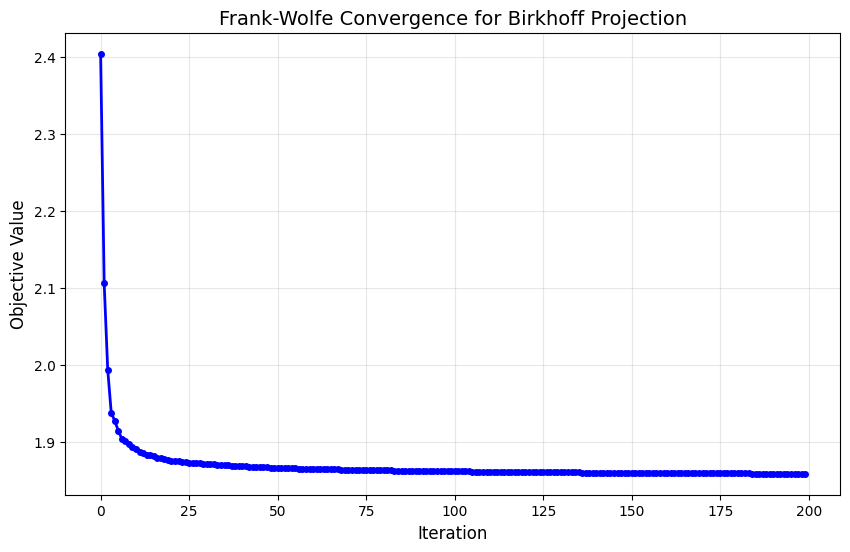

In [7]:
# Generate Y matrix
Y = np.random.rand(5, 5)

# Get algorithm results
X, objective_history = project_to_birkhoff_frank_wolfe(Y, max_iter=200)

# Plot history
plt.figure(figsize=(10, 6))
plt.plot(objective_history, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Objective Value', fontsize=12)
plt.title('Frank-Wolfe Convergence for Birkhoff Projection', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

### Result veryfication

In [8]:
n = X.shape[0]

print(X)

for i in range(n):
  print(f'row {i} sum: {round(np.sum(X[i]), 2)} column {i} sum: {round(np.sum(X.T[i]), 2)}')

[[0.04360414 0.48674667 0.07034287 0.13087795 0.26842836]
 [0.01072519 0.23890239 0.06977799 0.29393981 0.38665461]
 [0.02224704 0.20859296 0.74306067 0.01537415 0.01072519]
 [0.45647025 0.05503279 0.10609328 0.1934842  0.18891948]
 [0.46695338 0.01072519 0.01072519 0.36632388 0.14527236]]
row 0 sum: 1.0 column 0 sum: 1.0
row 1 sum: 1.0 column 1 sum: 1.0
row 2 sum: 1.0 column 2 sum: 1.0
row 3 sum: 1.0 column 3 sum: 1.0
row 4 sum: 1.0 column 4 sum: 1.0


Result: $X \in B_5$

# Subgradient method

### Implementation

In [14]:
# Define the loss function
def loss_function(A: np.ndarray, Sigma: np.ndarray, x: np.ndarray, y: np.ndarray):
  Uloss = np.clip(np.linalg.norm(sqrtm(A) @ (x - y), 2) - 1, a_min=0, a_max=np.inf)
  Vloss = np.clip(np.linalg.norm(Sigma @ x, ord=np.inf) - 1, a_min=0, a_max=np.inf)
  return Uloss + Vloss

# Set loss gradient
def loss_grad(A: np.ndarray, Sigma: np.ndarray, x: np.ndarray, y: np.ndarray): 
  Ugrad = np.zeros_like(x)
  Vgrad = np.zeros_like(x)
  Uloss = np.linalg.norm(sqrtm(A) @ (x - y), 2) - 1
  Vloss = np.linalg.norm(Sigma @ x, ord=np.inf) - 1
  if Uloss > 0:
    Ugrad = 2 * sqrtm(A).T @ sqrtm(A) @ (x - y)
  if Vloss > 0:
    sigma_vector = Sigma @ x
    Vgrad = np.zeros_like(sigma_vector)
    idx = np.argmax(sigma_vector)
    Vgrad[idx] = Sigma[idx, idx]

  return Ugrad + Vgrad

# Subgradient method function
def subgradient_method(A: np.ndarray, Sigma: np.ndarray, y: np.ndarray, x0: np.ndarray, max_iter=1000, tol=1e-6):
  n = y.shape[0]
  x = x0 # set x starting point
  x_list = []
  loss_list = []

  for k in range(max_iter):
    grad = loss_grad(A, Sigma, x, y)
    loss = loss_function(A, Sigma, x, y)
    alpha = 0.01

    # Adaptive step count
    if k > 0:
      x = x - alpha * np.sqrt(1 / k) * grad
    else:
      x = x - alpha * grad

    # Add point and loss to list
    x_list.append(x)
    loss_list.append(loss)

    # Stop if we come to solvation
    if k > 0 and loss < tol:
      print(f"Converged after {k} iterations.")
      break

  else: # If loop finishes without breaking
    print(f"Reached max iterations ({max_iter}).")
  return x_list, loss_list
  

### Set data

In [16]:
# Set data
A = np.array(
  [
    [1, 0],
    [-1, 1]
  ]
)
y = np.array((3, 2)).T
Sigma = np.array(
  [
    [0.5, 0],
    [0, 1.]
  ]
)

x0 = np.array((1, 2)).T

### Method performance

Reached max iterations (2000).


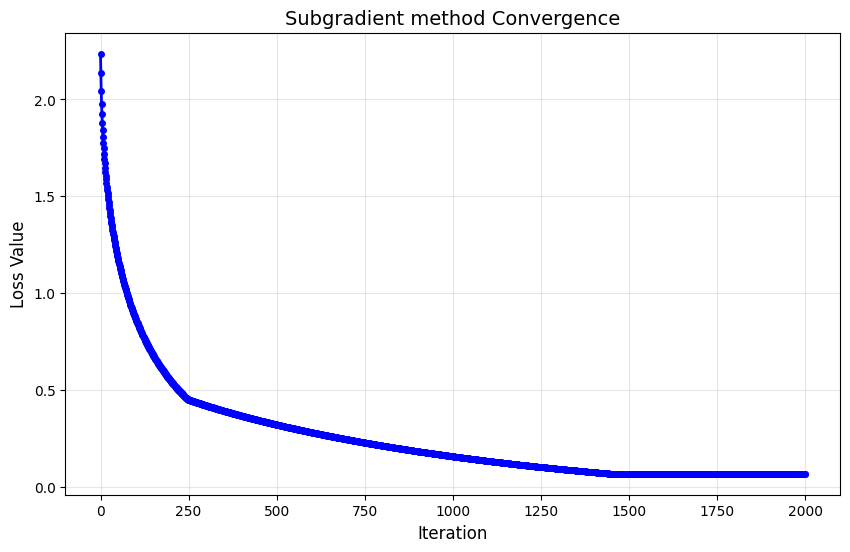

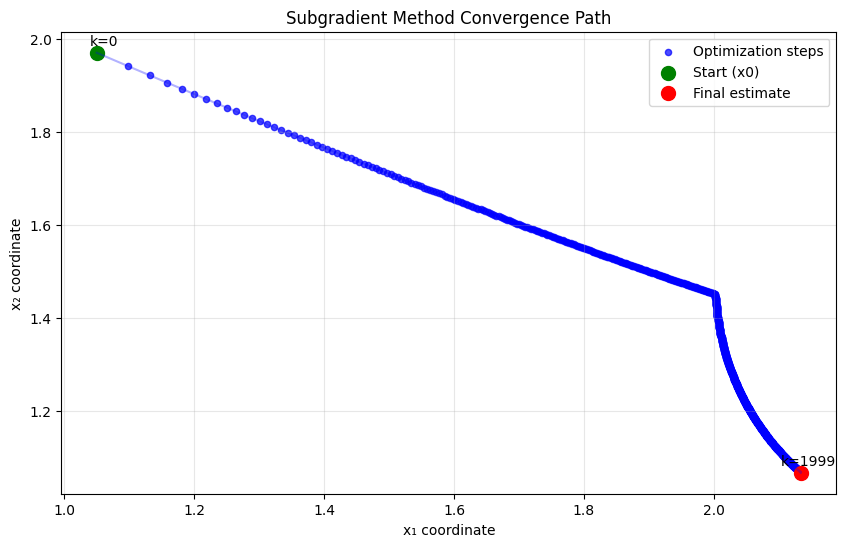

In [17]:
x_list, loss_list = subgradient_method(A, Sigma, y, x0, max_iter=2000)

# Plot history
plt.figure(figsize=(10, 6))
plt.plot(loss_list, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Subgradient method Convergence', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot x-dots method convergence
# Convert x_list to plottable coordinates
x1_coords = [x[0] for x in x_list]
x2_coords = [x[1] for x in x_list]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the path as connected dots
plt.plot(x1_coords, x2_coords, 'b-', alpha=0.3)  # Thin blue line for path
plt.scatter(x1_coords, x2_coords, c='blue', s=20, alpha=0.7, label='Optimization steps')  # Dots

# Mark start and end points
plt.scatter(x1_coords[0], x2_coords[0], c='green', s=100, label='Start (x0)')
plt.scatter(x1_coords[-1], x2_coords[-1], c='red', s=100, label='Final estimate')

# Add iteration labels
plt.annotate(f'k={0}', (x_list[0][0], x_list[0][1]), textcoords="offset points", xytext=(5,5), ha='center')
plt.annotate(f'k={len(x_list) - 1}', (x_list[-1][0], x_list[-1][1]), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('x₁ coordinate')
plt.ylabel('x₂ coordinate')
plt.title('Subgradient Method Convergence Path')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Result: Method converged to sets crossing area

# Proximal gradient method

In [21]:
# Define softmax function
@jit
def softmax(z):
    exp_z = jnp.exp(z - jnp.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

# Define cross-entropy loss
@jit
def cross_entropy_loss_log(w, X, y):
    predictions = X @ w
    n = len(X)
    log_likelihoods = jax.scipy.special.logsumexp(predictions, axis=1)
    cross_entropy = log_likelihoods - jnp.sum(jnp.multiply(predictions, y), axis=1)
    return (1/n) * jnp.sum(cross_entropy)

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def compute_optimal(X, y, lam):
    n, d = X.shape
    k = y.shape[1]  # Assuming y is one-hot encoded, number of classes

    # Define the variable for weights
    w = cp.Variable((d, k))
    
    # Construct the objective
    logits = X @ w
    log_likelihoods = cp.log_sum_exp(logits, axis=1)
    cross_entropy_loss = cp.sum(log_likelihoods) - cp.sum(cp.multiply(y, logits))
    
    # Add l1 regularization
    l1_reg = lam * cp.sum(cp.abs(w))
    
    # Total loss
    loss = (1/n) * cross_entropy_loss + l1_reg
    
    # Define the problem
    problem = cp.Problem(cp.Minimize(loss))
    
    # Solve the problem
    problem.solve()
    
    # Extract the optimal weights and minimum loss
    w_star = w.value
    f_star = problem.value
    
    return w_star, f_star

def generate_problem():
    # Fetch dataset from UCI repository
    dataset = fetch_ucirepo(id=697)
    
    # Extract features and targets
    X = dataset.data.features.values
    y = dataset.data.targets.values.flatten()

    # Create a mapping from unique labels to integers
    unique_labels = np.unique(y)
    num_classes = len(unique_labels)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels to integers using the mapping
    y_integers = jnp.array([label_to_int[label] for label in y])

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_integers, test_size=0.33, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # One-hot encoding using jax
    y_train_one_hot = jax.nn.one_hot(y_train, num_classes)
    y_test_one_hot = jax.nn.one_hot(y_test, num_classes)

    return X_train, y_train_one_hot, X_test, y_test_one_hot

def subgradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y)

    iter_start = time.time()
    for i in range(num_iters):
        # Compute gradient of cross-entropy
        grad_ce = jax.grad(cross_entropy_loss_log)(w, X, y)
        
        # Compute subgradient of L1 term (sign function)
        subgrad_l1 = lam * jnp.sign(w)
        
        # Combined subgradient
        subgrad = grad_ce + subgrad_l1
        
        # Update weights
        w = w - learning_rate * subgrad
        
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times


def proximal_gradient_method(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y)

    iter_start = time.time()
    for i in range(num_iters):
        # Compute gradient of smooth part (cross-entropy)
        grad_ce = jax.grad(cross_entropy_loss_log)(w, X, y)
        
        # Gradient step
        v = w - learning_rate * grad_ce
        
        # Proximal operator for L1 (soft-thresholding)
        w = jnp.sign(v) * jnp.maximum(jnp.abs(v) - learning_rate * lam, 0)
        
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

# Compute accuracy
def compute_accuracy(w, X, y):
    predictions = softmax(X @ w)
    predicted_classes = jnp.argmax(predictions, axis=1)
    true_classes = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_classes == true_classes)
    return accuracy

# Compute metrics
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam):
    f = lambda w: cross_entropy_loss_log(w, X_train, y_train) + lam * jnp.sum(jnp.abs(w))
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
        "sparsity": [jnp.mean(jnp.abs(x) < 1e-5) for x in trajectory]
    }
    return metrics

def run_experiments(params):
    lam = params["lam"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem()
    n_features = X_train.shape[1]
    n_classes = len(y_train[0])
    params["n_features"], params["n_classes"] = n_features, n_classes
    
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, n_classes))
    x_star, f_star = compute_optimal(X_train, y_train, lam)
    print(f"Optimal accuracy {compute_accuracy(x_star, X_train, y_train)}")

    for method in methods:
        if method["method"] == "Subgrad":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = subgradient_descent(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)
        elif method["method"] == "Proximal":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = proximal_gradient_method(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    lam = params["lam"]
    
    plt.suptitle(f"Convex multiclass regression. lam={lam}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method + f" sparsity {metrics['sparsity'][-1]:.3f}")
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{lam}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

# Stochastic gradient methods

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

def stochastic_gradient_descent(X, y, x_0, learning_rate, iterations, loss_function, batch_size=1, mu=0):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        X_batch, y_batch = X[indices], y[indices]
        f_batch = lambda w: loss_function(w, X=X_batch, y=y_batch, mu=mu)
        grad_f_batch = grad(f_batch)
        x -= learning_rate * grad_f_batch(x)
        trajectory.append(x)
        flops += (2 * n * batch_size + n) 
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory


def sag(X, y, x_0, learning_rate, iterations, loss_function, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0.copy()
    gradients = jnp.zeros((m, n))
    average_grad = jnp.zeros(n)
    flops = 0
    trajectory = [x.copy()]
    flops_trajectory = [flops]
    
    grad_loss = grad(loss_function)
    
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        
        for idx in indices:
            new_grad = grad_loss(x, X[idx:idx+1], y[idx:idx+1], mu)
            average_grad += (new_grad - gradients[idx]) / m
            gradients = gradients.at[idx].set(new_grad)
            flops += 2 * n
        x -= learning_rate * average_grad
        trajectory.append(x.copy())
        flops += n
        flops_trajectory.append(flops)
    
    return trajectory, flops_trajectory

def svrg(X, y, x_0, learning_rate, epoch_length, iterations, loss_function, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0.copy()
    flops = 0
    trajectory = [x.copy()]
    flops_trajectory = [flops]
    
    grad_loss = grad(loss_function)
    
    num_epochs = max(1, iterations // epoch_length)
    
    for _ in range(num_epochs):
        full_grad = grad_loss(x, X, y, mu)
        flops += 2 * m * n
        
        x_tilde = x.copy()
        
        for _ in range(epoch_length):
            indices = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X[indices], y[indices]

            grad_current = grad_loss(x, X_batch, y_batch, mu)
            grad_snapshot = grad_loss(x_tilde, X_batch, y_batch, mu)
            
            variance_reduced_grad = grad_current - grad_snapshot + full_grad
            x -= learning_rate * variance_reduced_grad
            
            trajectory.append(x.copy())
            flops += 4 * n * batch_size + 3 * n
            flops_trajectory.append(flops)
    
    return trajectory, flops_trajectory

def compute_metrics(trajectory, x_star, f_star, f, flops_trajectory):
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "flops": flops_trajectory,
    }
    return metrics

def run_experiments(params, generate_problem, loss_function):
    m, n, mu = params["m"], params["n"], params["mu"]
    methods = params["methods"]
    results = {}

    X, y = generate_problem(m, n, mu)
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n,))
    # Compute the optimal solution using CVXPY
    x_star, f_star = compute_optimal(X, y, mu)

    for method_params in methods:
        method = method_params["method"]
        if method == "SGD":
            trajectory, flops_trajectory = stochastic_gradient_descent(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], loss_function, method_params["batch_size"], mu
            )
        elif method == "SAG":
            trajectory, flops_trajectory = sag(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], loss_function, method_params["batch_size"], mu
            )
        elif method == "SVRG":
            trajectory, flops_trajectory = svrg(
                X, y, x_0, method_params["learning_rate"], method_params["epoch_length"], method_params["iterations"], loss_function, method_params["batch_size"], mu
            )
        label = f"{method} batch {method_params['batch_size']}"
        results[label] = compute_metrics(trajectory, x_star, f_star, f=lambda x: loss_function(x, X, y, mu), flops_trajectory=flops_trajectory)
    return results

def plot_results(results, params):
    plt.figure(figsize=(10, 3.5))
    mu = params["mu"]
    m = params["m"]
    n = params["n"]
    
    if mu > 1e-2:
        plt.suptitle(f"Strongly convex binary logistic regression. m={m}, n={n}, mu={mu}.")
    else:
        plt.suptitle(f"Convex binary logistic regression. m={m}, n={n}, mu={mu}.")

    plt.subplot(1, 3, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 3)
    for method, metrics in results.items():
        plt.plot(metrics["flops"], metrics['f_gap'])
    plt.xlabel('FLOPS')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"sgd_{mu}_{m}_{n}.pdf")
    plt.show()

### Binary logistic problem

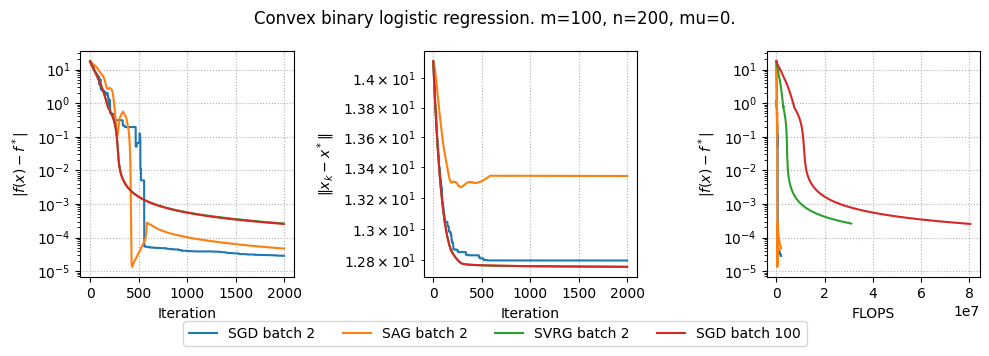

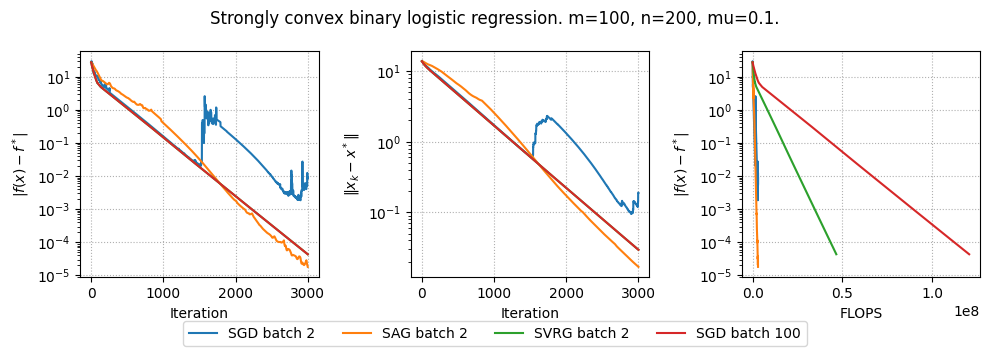

In [29]:
def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

def generate_logistic_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//2, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y

# convex case
params = {
    "mu": 0,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 100,
            "iterations": 2000,
        },
    ]
}

results = run_experiments(params, generate_logistic_problem, logistic_loss)
plot_results(results, params)

# strongly convex case
params = {
    "mu": 1e-1,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SAG",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SVRG",
            "learning_rate": 2e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 100,
            "iterations": 3000,
        },
    ]
}

results = run_experiments(params, generate_logistic_problem, logistic_loss)
plot_results(results, params)

### Linear least squares problem

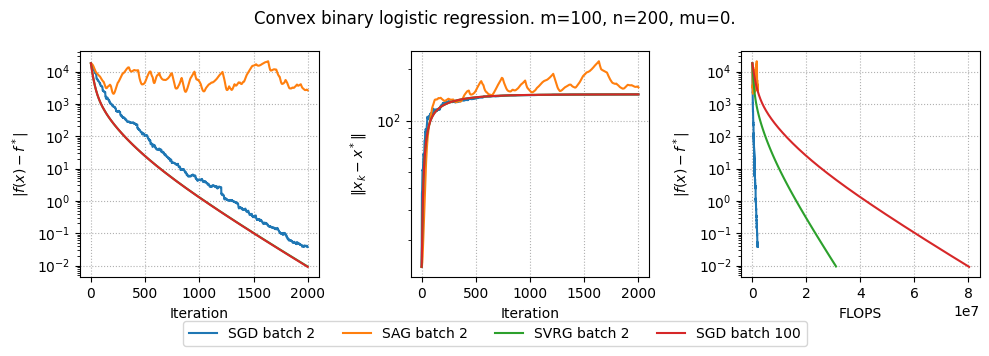

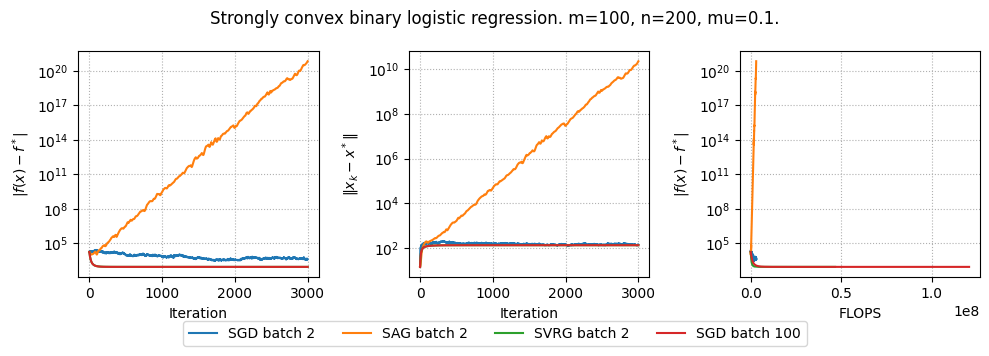

In [30]:
def least_squares_loss(w, X, y, mu=1):
    m, n = X.shape
    residuals = X @ w - y
    return jnp.sum(residuals ** 2) / (2 * m) + mu / 2 * jnp.sum(w ** 2)

def generate_regression_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_regression(n_features=n, n_samples=m, noise=1e-3, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y

# convex case
params = {
    "mu": 0,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 100,
            "iterations": 2000,
        },
    ]
}

results = run_experiments(params, generate_regression_problem, least_squares_loss)
plot_results(results, params)

# strongly convex case
params = {
    "mu": 1e-1,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SAG",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SVRG",
            "learning_rate": 2e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 100,
            "iterations": 3000,
        },
    ]
}

results = run_experiments(params, generate_regression_problem, least_squares_loss)
plot_results(results, params)

# Neural network training

### Adam

In [32]:
adam = optax.nadam(learning_rate=1e-3)

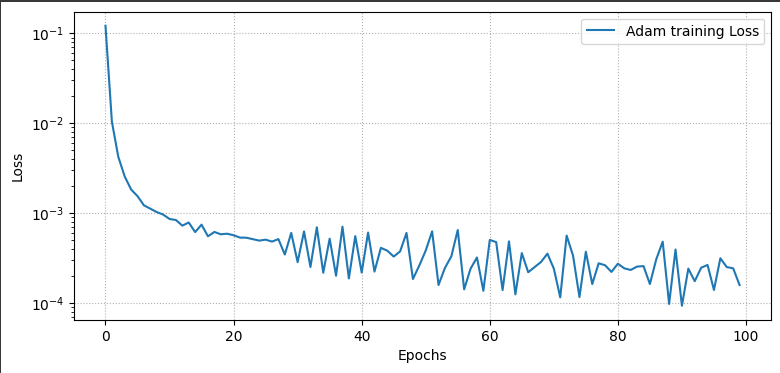

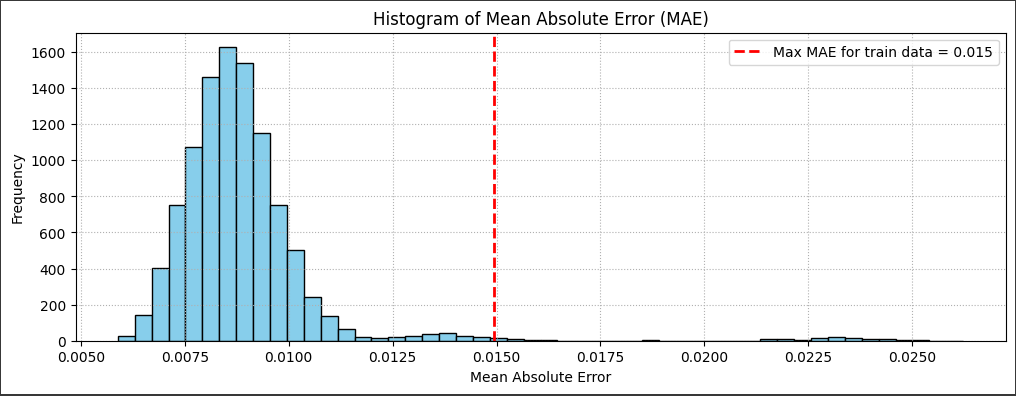

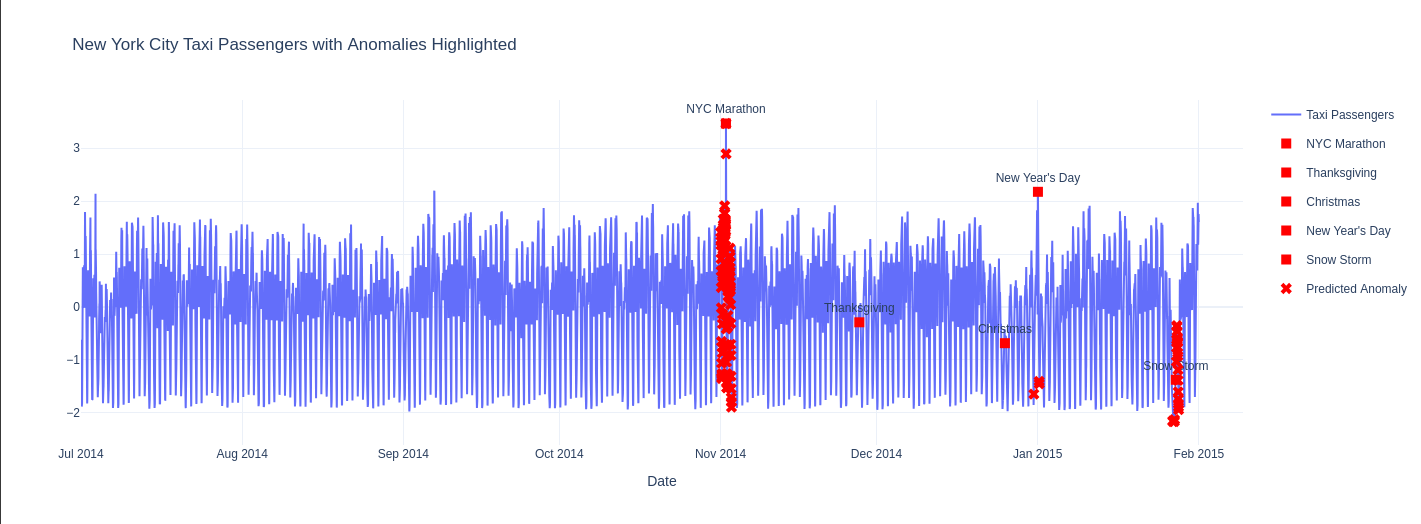

### Adagrad

In [ ]:
tx_adadelta = optax.adadelta(learning_rate=1e-3)

# Big Models

In [ ]:
!pip install -q transformers datasets accelerate nvidia-ml-py3

# Description

In this assignment, you will train a language model (LM) using the TinyStories dataset, focusing on optimizing model performance within the constraints of Google Colab’s hardware. For the sake of speed, we will do it on the part of the dataset.

```
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun.
Beep was a healthy car because he always had good fuel....
```

Your objective is to maximize the size of the model without exceeding the available computational resources (~ 16GB VRAM). You could start with the Hugging Face Transformers library and experiment with various memory optimization techniques, such as (but not limited to):

 * Different batch size
 * Different optimizer
 * Gradient accumulation
 * Activation checkpointing
 * CPU offloading
 * 8bit optimizers

You have a baseline of training gpt-2 model prepared in this  colab notebook. You can easily switch it to opt-350m, opt-1.3b, gpt2 etc. You can find a great beginner-level guide on the topic [here](https://huggingface.co/docs/transformers/v4.18.0/en/performance).

```
A long time ago in a galaxy far far away... a little girl named Lily was playing in the garden. She was so excited! She wanted to explore the garden and see what was around her.
Suddenly, she heard a loud noise. Lily looked up and saw a big, hairy creature. Lily was so excited! She ran to the creature and grabbed it by the arm. The creature was so big and hairy that Lily couldn't help but laugh.
```

![](https://hse24.fmin.xyz/gpt2_generation.jpeg)

You have to fill this table with your description/observations.

| Setup | # of parameters | GPU peak memory, MB | Final eval loss | Batch Size | Time to run 5 epochs, s | Generation example | Comment |
|:---:|:---:|:---:|:---:|:---:|:---:|:---------:|:---------:|
| Baseline (GPT2) | 124 M | 10101 | 2.126 | 8 | 377.29 | `A long time ago in a galaxy far far away... there was a little girl named Lina. She was very curious and wanted to explore. One day, she was walking in the forest when she saw a big tree. She looked up and saw a big, shiny tree. She was so excited! She jumped up and ran to the tree, but it was too big. Lina was so excited and she ran to the tree and jumped up. She ran to the tree` | The generation seems more interesting, despite the fact, that eval loss is higher. |
|  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |

For each unique trick for memory optimization, you will get 4 points (maximum 20 points). A combination of tricks is not counted as a unique trick, but will, probably, be necessary to train big models. The maximum grade is bounded with the size of the trained model:

* If the model size you train is <= 125M - you can get a maximum of 8 points.
* If the model size you train is 126M <= 350M - you can get a maximum of 12 points.
* If the model size you train is 350M <= 1B - you can get a maximum of 16 points.
* If you fit 1B model or more - you can get a maximum 20 points.

### Baseline

In [ ]:
import torch

torch.cuda.synchronize()
torch.cuda.empty_cache()  # Clears the cache
torch.cuda.reset_peak_memory_stats()  #

from transformers import AutoModelForCausalLM, AutoTokenizer, \
    TrainingArguments, Trainer, logging, DataCollatorForLanguageModeling
from datasets import load_dataset
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

print("💎 Before training:")
print_gpu_utilization()

# Suppress less critical logs
logging.set_verbosity_error()

# Load the dataset with both training and evaluation splits
train_dataset = load_dataset("roneneldan/TinyStories", split="train[:500]")
eval_dataset = load_dataset("roneneldan/TinyStories", split="train[500:1000]")

HF_cardname = "openai-community/gpt2"
# HF_cardname = "openai-community/gpt2-medium"
# HF_cardname = "openai-community/gpt2-large"
# HF_cardname = "openai-community/gpt2-XL"
# HF_cardname = "facebook/opt-125m"
# HF_cardname = "facebook/opt-350m"
# HF_cardname = "facebook/opt-1.3b"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(HF_cardname, use_fast=False)
EOS_TOKEN = tokenizer.eos_token

# Ensure the tokenizer has a padding token, set EOS_TOKEN as padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = EOS_TOKEN

# Function to process the dataset
def formatting_func(examples):
    inputs = [tokenizer(text + EOS_TOKEN, truncation=True, max_length=512, padding="max_length", return_tensors="pt") for text in examples['text']]
    return {'input_ids': [input['input_ids'].squeeze() for input in inputs], 'labels': [input['input_ids'].squeeze() for input in inputs]}

# Process the datasets
processed_train_dataset = train_dataset.map(formatting_func, batched=True, remove_columns=["text"])
processed_eval_dataset = eval_dataset.map(formatting_func, batched=True, remove_columns=["text"])

# Initialize Data Collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

print("💎 Dataset loaded")
print_gpu_utilization()

# Define and load the model
model = AutoModelForCausalLM.from_pretrained(HF_cardname)

print("💎 Model loaded")
print_gpu_utilization()

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

# Initialize the trainer with the data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_dataset,
    eval_dataset=processed_eval_dataset,
    data_collator=data_collator
)

# Start training
trainer.train()

def print_summary(trainer):
    # Access training result metrics directly from the trainer state
    print(f"💎 Training time: {trainer.state.log_history[-1]['train_runtime']:.2f} seconds")
    print(f"Samples/second: {trainer.state.log_history[-1]['train_samples_per_second']:.2f}")
    print_gpu_utilization()
    num_params = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {num_params}")

print_summary(trainer)

In [ ]:
# Encode the prompt text
input_ids = tokenizer.encode(
    "A long time ago in a galaxy far far away...",
    return_tensors="pt").cuda()

# Generate text using the model
output_ids = model.generate(input_ids, max_length=100)

# Decode the generated ids to text
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print the generated text
print(generated_text)